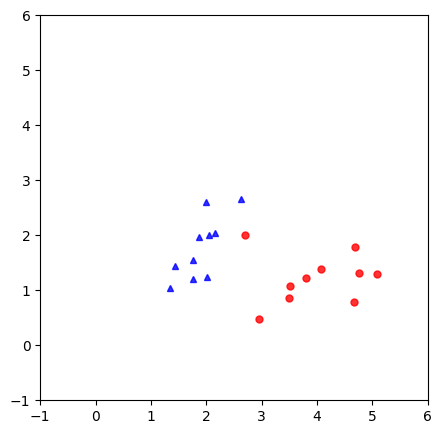

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
np.random.seed(21)

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()

ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

In [77]:
# Cách 1: build model with st function
from cvxopt import matrix, solvers
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1) 
K = matrix(V.T.dot(V))
p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))) 
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)
l = np.array(sol['x']) 

S = np.where(l > 1e-5)[0] # support set 
S2 = np.where(l < .999*C)[0]
M = [val for val in S if val in S2] # intersection of two lists

XT = X.T # we need each column to be one data point in this alg 
VS = V[:, S]
lS = l[S]
yM = y[0][M]

XM = XT[M, :].T
w_dual = VS.dot(lS).reshape(-1, 1) 
b_dual = np.mean(yM.T - w_dual.T.dot(XM)) 
print(w_dual.T, b_dual)

[[-5.54276837  2.41628387]] 9.132906850859632


In [78]:
# Cach 2: Xây dựng phương pháp giải bài toán tối ưu không ràng buộc
X0_bar = np.vstack((X0.T, np.ones((1,N))))
X1_bar = np.vstack((X1.T, np.ones((1,N))))
Z = np.hstack((X0_bar, -X1_bar))
print(X0_bar)
print(X1_bar)
print(Z)

C = 200
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23) 
    return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias 

def grad(w): 
    u = w.T.dot(Z) # as in (23) 
    H = np.where(u < 1)[1] 
    ZS = Z[:, H] 
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w) 
    g[-1] -= lam*w[-1] # no weight decay on bias 
    return g

eps = 1e-6 
def num_grad(w): 
    g = np.zeros_like(w) 
    for i in range(len(w)): 
        wp = w.copy() 
        wm = w.copy() 
        wp[i] += eps 
        wm[i] -= eps  
        g[i] = (cost(wp) - cost(wm))/(2*eps) 
    return g  
 
w0 = np.random.randn(X0_bar.shape[0], 1)  
g1 = grad(w0) 
g2 = num_grad(w0) 
diff = np.linalg.norm(g1 - g2) 
# print('Gradient different: %f' %diff) 

def grad_descent(w0, eta): 
    w = w0 
    it = 0  
    while it < 100000: 
        it = it + 1 
        g = grad(w) 
        w -= eta*g 
        # if (it % 10000) == 1: 
            # print('iter %d' %it + ' cost: %f' %cost(w)) 
        if np.linalg.norm(g) < 1e-5: 
            break  
    return w  
w0 = np.random.randn(X0_bar.shape[0], 1)  
w = grad_descent(w0, 0.001) 
w_hinge = w[:-1].reshape(-1, 1) 
b_hinge = w[-1] 
print(w_hinge.T, b_hinge)

[[-5.55011742  2.41865543]] [9.14708377]


In [79]:
# Cách 3: using library
from sklearn.svm import SVC

y1 = y.reshape((2*N))
X1 = X.T
clf = SVC(kernel='linear', C = 100)
clf.fit(X1, y1)

w = clf.coef_
b = clf.intercept_
print(w, b)

print(np.sign(np.dot(w, X)+ b))

[[-5.54202362  2.4156074 ]] [9.13241559]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1.]]


In [80]:
# index range
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred1 = np.sign(np.dot(w_dual.T, X)+ b_dual)
y_pred2 = np.sign(np.dot(w_hinge.T, X)+ b_hinge)
y_pred3 = np.sign(np.dot(w, X)+ b)

data = {'accuracy_score': [accuracy_score(y, y_pred1), accuracy_score(y, y_pred2), accuracy_score(y, y_pred3)],
        'confusion_matrix': [ confusion_matrix(y.T, y_pred1.T),  confusion_matrix(y.T, y_pred1.T),  confusion_matrix(y.T, y_pred1.T)]}

df = pd.DataFrame(data, index=['model1', 'model2', 'model3'])
print(df)




        accuracy_score    confusion_matrix
model1             1.0  [[10, 0], [0, 10]]
model2             1.0  [[10, 0], [0, 10]]
model3             1.0  [[10, 0], [0, 10]]
